In [1]:
import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter
from scipy.optimize import curve_fit

# import Python functions 
import sys
sys.path.append('../')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN

In [2]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

# Sets data location
experiment = 'E338'
runname = '12710'

In [3]:
# Loads dataset
dataloc = '../data/raw/' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = [1]

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

# cropping aspect ratio 
xrange = 100 
yrange = xrange


# gaussian filter parameter
hotPixThreshold = 1e3
sigma = 1
threshold = 5

In [4]:
# Extract current profiles and 2D LPS images 
xtcavImages_list = []
horz_proj_list = []
LPSImage = [] 

for a in range(len(stepsAll)):
    if len(stepsAll) == 1:
        raw_path = data_struct.images.DTOTR2.loc
    else: 
        raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = '../data/raw/'+ experiment + '/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    DTOTR2data_step = np.transpose(data_raw, (2, 1, 0))
    xtcavImages_step = DTOTR2data_step - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(DTOTR2data_step.shape[2]):
        if idx is None:
            continue
        image = xtcavImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        img_filtered = median_filter(image_cropped, size=3)
        hotPixels = img_filtered > hotPixThreshold
        img_filtered = np.ma.masked_array(img_filtered, hotPixels)
        processed_image = gaussian_filter(img_filtered, sigma=sigma, radius = 6*sigma + 1)
        processed_image[processed_image < threshold] = 0.0
        Nrows = np.array(image_cropped).shape[0]
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        horz_proj_idx = np.sum(image_cropped, axis=0)
        horz_proj_idx = horz_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        image_ravel = image_shifted.ravel()
        # combine current profiles into one array 
        horz_proj_list.append(horz_proj_idx)

        # combine images into one array 
        xtcavImages_list.append(image_shifted)
        LPSImage.append([image_ravel])

xtcavImages = np.concatenate(xtcavImages_list, axis=2)
horz_proj = np.concatenate(horz_proj_list, axis=1)
LPSImage = np.concatenate(LPSImage, axis = 0)

# Keeps only the data with a common index
DTOTR2commonind = data_struct.images.DTOTR2.common_index -1 
horz_proj = horz_proj[:,DTOTR2commonind]
xtcavImages = xtcavImages[:,:,DTOTR2commonind]
LPSImage = LPSImage[DTOTR2commonind,:]

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_25887/46796503.py:40: RuntimeWarning: invalid value encountered in divide
  centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)


In [9]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0]
plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0]
all_idx = np.append(minus_90_idx,plus_90_idx)

currentProfile_all = [] 

# Process all degree shots
for ij in range(len(all_idx)):
    idx = all_idx[ij]
    streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapezoid(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_all.append(currentProfile)
    
currentProfile_all = np.array(currentProfile_all)

In [10]:
# Filter out "bad" shots with Bi-Gaussian fit 
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

amp1 = []
R_squared = []

for ij in range(len(all_idx)):
    y = currentProfile_all[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    if xtcavPhase[all_idx][ij] < 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60 + ij*0.15, 4]
    elif xtcavPhase[all_idx][ij] > 0:
        initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 60, 4]
    
    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        amp1.append(np.nan)
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    amp1.append(A1)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
amp1 = np.array(amp1)
R_squared = np.array(R_squared)
goodShots = np.where((R_squared > 0.97) & (amp1 < 50))[0] # set requirements for "good" shots

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_25887/617765087.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


### MLP 

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

images = LPSImage[all_idx,:][goodShots,:]
steps = data_struct.scalars.steps[DTOTR2commonind]
predictor = np.vstack((bsaScalarData[:,goodShots], steps[goodShots])).T

x_scaler = MinMaxScaler()
iz_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(predictor)
Iz_scaled = iz_scaler.fit_transform(images)

# 80/20 train-test split
x_train_full, x_test_scaled, Iz_train_full, Iz_test_scaled = train_test_split(
    x_scaled, Iz_scaled, test_size=0.2)

# 20% validation split 
x_train_scaled, X_val, Iz_train_scaled, Y_val = train_test_split(
    x_train_full, Iz_train_full, test_size=0.2)

# compress pixels 
pca = PCA(n_components=50)
compressed_targets = pca.fit_transform(Iz_train_scaled) 
Y_val = pca.transform(Y_val)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)
Y_train = torch.tensor(compressed_targets, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
Y_test = torch.tensor(Iz_test_scaled, dtype=torch.float32)

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)


In [114]:
i = 92

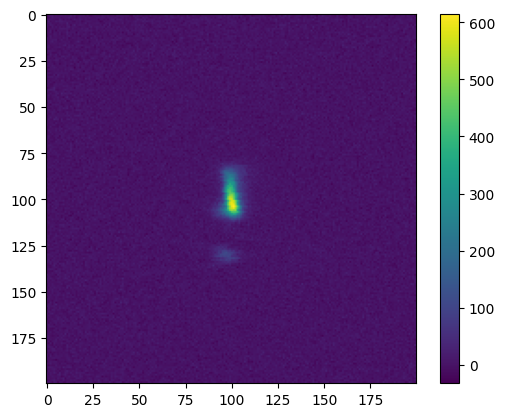

In [120]:
plt.imshow(Iz_test_true.T.reshape(200,200,107)[:,:,i])
plt.colorbar()

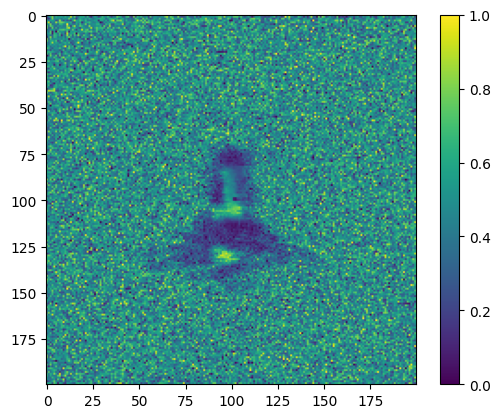

In [116]:
plt.imshow(Iz_test_scaled.T.reshape(200,200,107)[:,:,i])
plt.colorbar()

In [165]:
import time

# Define MLP structure
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000,1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, out_dim)
        )
    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1], Y_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
loss_fn = nn.L1Loss()

# Define custom weighted MSE loss function 
def custom_loss( y_pred,y_true): 
    mse = (y_true - y_pred)**2
    weights = 1 + 0.5*((y_true < 0.2) | (y_true > 0.8)).float()
    return torch.mean(weights*mse)

# Training loop 
n_epochs = 200
patience = 25
best_val_loss = float('inf')
early_stop_counter = 0

t0 = time.time()

# Fit the nn model on the training set
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        pred = model(xb)
        loss = custom_loss(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dl)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = custom_loss(val_pred, Y_val).item()
        val_losses.append(val_loss)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            break
    
model.load_state_dict(best_model_state)
    
# Evaluate model
model.eval()
with torch.no_grad():
    pred_train_scaled = model(X_train).numpy()
    pred_test_scaled = model(X_test).numpy()

# Inverse transform predictions
pred_train_full = iz_scaler.inverse_transform(pca.inverse_transform(pred_train_scaled))
pred_test_full = iz_scaler.inverse_transform(pca.inverse_transform(pred_test_scaled))
Iz_train_true = iz_scaler.inverse_transform(Iz_train_scaled)
Iz_test_true = iz_scaler.inverse_transform(Iz_test_scaled)
elapsed = time.time() - t0
print("Elapsed time [mins] = {:.1f} ".format(elapsed/60))

# Compute R²
def r2_score(true, pred):
    RSS = np.sum((true - pred)**2)
    TSS = np.sum((true - np.mean(true))**2)
    return 1 - RSS / TSS if TSS != 0 else s0

print("Train R²: {:.2f} %".format(r2_score(Iz_train_true.ravel(), pred_train_full.ravel()) * 100))
print("Test R²: {:.2f} %".format(r2_score(Iz_test_true.ravel(), pred_test_full.ravel()) * 100))


Elapsed time [mins] = 0.0 
Train R²: 79.49 %
Test R²: 77.50 %


In [166]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image(idx):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9, 3))
    im1 = ax1.imshow(Iz_test_true.T.reshape(200,200,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto', vmin = 0, vmax = 600)
   
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = "True")
    ax1.set(xlim = (0,200))
    ax1.set(ylim= (0,200))

    im2 = ax2.imshow(pred_test_full.T.reshape(200,200,Iz_test_true.shape[0])[:,:,idx], cmap = "jet",aspect='auto',vmin = 0, vmax = 600)
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")
    ax2.set(xlim = (0,200))
    ax2.set(ylim= (0,200))
    cbar = fig.colorbar(im1, ax=[ax1, ax2], fraction=0.16, pad=0.04)
    # cbar.set_label("Current [arb. units]")
    # plt.tight_layout()
    fig.show()

# Create slider
interact(plot_xtcav_image, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=106), Output()), _dom_classes=('widget-interac…

<function __main__.plot_xtcav_image(idx)>

In [ ]:
streakedProfile = horz_proj[:,idx]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_all.append(currentProfile)

In [167]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image(idx):

    horz_proj_true = np.sum(Iz_test_true.T.reshape(200,200,Iz_test_true.shape[0])[:,:,idx], axis = 0)
    tvar = np.arange(1, len(horz_proj_true) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar) 
    # prefactor = charge[0, idx] / np.trapz(horz_proj_true, tvar) # needs to be idx from entire data set ==> manual train/test split with test_idx
    plt.plot(horz_proj_true, label = "True", alpha = 0.5)
   
    # ax1.suptitle(f"Current Profile Index: {idx}")
    plt.ylabel("y [pix]")
    plt.xlabel("Time [fs]")
    # ax1.set(xlim = (0,200))
    # ax1.set(ylim= (0,200))

    horz_proj_pred = np.sum(pred_test_full.T.reshape(200,200,Iz_test_true.shape[0])[:,:,idx], axis = 0)
    plt.plot(horz_proj_pred, label = "Prediction", alpha = 0.5)
    # ax2.set(xlim = (0,200))
    # ax2.set(ylim= (0,200))
    # cbar.set_label("Current [arb. units]")
    # plt.tight_layout()
    plt.legend()
    plt.show()

# Create slider
interact(plot_xtcav_image, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=106), Output()), _dom_classes=('widget-interac…

<function __main__.plot_xtcav_image(idx)>

### CNN Decoder

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim

In [128]:
class ScalarToImage(nn.Module):
    def __init__(self, num_features, latent_dim=1024):
        super().__init__()
        
        # Step 1: MLP to project scalars into latent vector
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
            nn.ReLU()
        )
        
        # Step 2: Reshape latent into [batch, channels, h, w]
        self.latent_dim = latent_dim
        self.init_channels = 64
        self.init_hw = int((latent_dim // (self.init_channels))**0.5)  # e.g. 4, 8, or 10
        self.fc_to_conv = nn.Linear(latent_dim, self.init_channels * self.init_hw * self.init_hw)
        
        # Step 3: CNN decoder to upsample to 200x200
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.init_channels, 64, kernel_size=4, stride=2, padding=1),  # 2x up
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 4x up
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 8x up
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),  # output 1 channel
            nn.Sigmoid()  # normalize [0,1]
        )

    def forward(self, x):
        # x: [batch, num_features]
        latent = self.fc(x)  # [batch, latent_dim]
        conv_input = self.fc_to_conv(latent)  # [batch, C*H*W]
        conv_input = conv_input.view(-1, self.init_channels, self.init_hw, self.init_hw)
        out = self.decoder(conv_input)
        
        # Resize to exactly 200x200
        out = F.interpolate(out, size=(200, 200), mode="bilinear", align_corners=False)
        return out

In [163]:
images = xtcavImages[:,:,all_idx][:,:,goodShots]
images = np.moveaxis(images, -1, 0)
steps = data_struct.scalars.steps[DTOTR2commonind]
predictor = np.vstack((bsaScalarData[:,goodShots], steps[goodShots])).T

x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(predictor)



# 80/20 train-test split
x_train_full, x_test_scaled, Iz_train_full, Iz_test_scaled = train_test_split(
    x_scaled, images, test_size=0.2)

# 20% validation split 
x_train_scaled, X_val, Iz_train_scaled, Y_val = train_test_split(
    x_train_full, Iz_train_full, test_size=0.2)


# Convert to PyTorch tensors
X_train = torch.tensor(x_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(x_test_scaled, dtype=torch.float32)

Y_train = torch.tensor(Iz_train_scaled, dtype=torch.float32).unsqueeze(1)
Y_val = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
Y_test = torch.tensor(Iz_test_scaled, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
test_ds = TensorDataset(X_test, Y_test)

train_dl = DataLoader(train_ds, batch_size=24, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=24, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=24, shuffle=False)

In [164]:
model = ScalarToImage(num_features=X_train.shape[1])  # from my earlier code
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)  # MAE+SSIM
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # validation
    model.eval()
    with torch.no_grad():
        val_loss = sum(loss_fn(model(xv), yv).item() for xv, yv in val_dl) / len(val_dl)
    print(f"Epoch {epoch+1}: train_loss={total_loss/len(train_dl):.4f}, val_loss={val_loss:.4f}")

Epoch 1: train_loss=699.2307, val_loss=661.8526
Epoch 2: train_loss=699.4144, val_loss=661.5002
Epoch 3: train_loss=701.9931, val_loss=659.5261
Epoch 4: train_loss=697.9767, val_loss=659.2382
Epoch 5: train_loss=699.7954, val_loss=659.2203
Epoch 6: train_loss=696.4934, val_loss=659.2104
Epoch 7: train_loss=694.9080, val_loss=659.2063
Epoch 8: train_loss=703.7696, val_loss=659.2042
Epoch 9: train_loss=698.4069, val_loss=659.2027
Epoch 10: train_loss=698.1187, val_loss=659.2012
Epoch 11: train_loss=700.0003, val_loss=659.1998
Epoch 12: train_loss=703.7362, val_loss=659.1983
Epoch 13: train_loss=702.7694, val_loss=659.1969
Epoch 14: train_loss=699.8330, val_loss=659.1955
Epoch 15: train_loss=697.9525, val_loss=659.1941
Epoch 16: train_loss=692.6214, val_loss=659.1928
Epoch 17: train_loss=703.9048, val_loss=659.1913
Epoch 18: train_loss=693.1356, val_loss=659.1898
Epoch 19: train_loss=700.8662, val_loss=659.1880
Epoch 20: train_loss=696.8754, val_loss=659.1858
Epoch 21: train_loss=700.2992

In [165]:
# Evaluate model
model.eval()
with torch.no_grad():
    pred_train_scaled = model(X_train).numpy()
    pred_test_scaled = model(X_test).numpy()

# Inverse transform predictions
pred_train_full = pred_train_scaled[:,0,:,:]
pred_test_full = pred_test_scaled[:,0,:,:]
Iz_train_true = Iz_train_scaled
Iz_test_true = Iz_test_scaled

In [166]:
from ipywidgets import interact, IntSlider
def plot_xtcav_image(idx):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3))
    ax1.imshow(Iz_test_true[idx,:,:], cmap = "jet",aspect='auto')
   
    # ax1.suptitle(f"Current Profile Index: {idx}")
    ax1.set(ylabel="y [pix]")
    ax1.set(xlabel = "Time [fs]")
    ax1.set(title = "True")
    ax1.set(xlim = (0,200))
    ax1.set(ylim= (0,200))

    ax2.imshow(pred_test_full.T[idx,:,:], cmap = "jet",aspect='auto')
    ax2.set(xlabel = "Time [fs]")
    ax2.set(ylabel = "y [pix]")
    ax2.set(title = "Prediction")
    ax2.set(xlim = (0,200))
    ax2.set(ylim= (0,200))
    plt.tight_layout()
    fig.show()

# Create slider
interact(plot_xtcav_image, idx=IntSlider(min=0, max=pred_test_full.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=106), Output()), _dom_classes=('widget-interac…

<function __main__.plot_xtcav_image(idx)>

### GAN 

In [88]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable 

import torch.nn as nn
import torch.nn.functional as F
import torch

In [96]:
channels = 1
img_size = 200
img_shape = (channels, img_size, img_size)
latent_dim = 100
cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()